In [ ]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet
!{sys.executable} -m pip install torch --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
from sklearn.linear_model import LinearRegression

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

print('Is cuda?', torch.cuda.is_available())

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 3]

Is cuda? True


In [ ]:
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')


torch.manual_seed(3)


Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Define normalisation of voltage channels

Vmax =  max((max(x) for x in dat['V']))
Vmin = min((min(x) for x in dat['V']))
xmax = max(dat['cursorX'])
xmin = min(dat['cursorX'])
ymax = max(dat['cursorY'])
ymin = min(dat['cursorY'])

def Vnormalise(_V):
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

In [ ]:
# Load patient 2
dat = alldat[0, 2]

V = dat['V']
nt, nchan = V.shape
print(nt, nchan)

cx = Xnormalise(dat['cursorX'].flatten())
cy = Ynormalise(dat['cursorY'].flatten())
for c in range(nchan):
    V[:,c] = normalise(V[:,c])

nt, nchan = V.shape

134360 64


In [ ]:
#Define matrix construction
import numpy as np
from sklearn.linear_model import LinearRegression

def hindsight_indices(i, h, l, w):
  indexes = []
  indexes.append(i)
  for window in range(w):
     windowed_index = i - w
     indexes.append(windowed_index) 
  for hindsight in range(h):
    hindsight_index = i - (hindsight+1)*l 
    indexes.append(hindsight_index)
    for window in range(w):
     windowed_index = hindsight_index - w
     indexes.append(windowed_index) 

  return indexes

def future_indices(i, f):
  indexes = []
  indexes.append(i)
  for future in range(f):
    future_index = i + (future+1)*40
    indexes.append(future_index)
  return indexes

def construct_matrices (_V, _cx, _cy, _h, _l, _w, _f):
    # Generate feature indices
    i0 = _h*_l +_w 
    iN = nt - _f*40

    inputs = []
    targets = []

    flip = True
    for i in np.arange(i0, iN, 1, dtype=int):
      hix = hindsight_indices(i, _h, _l, _w)
      fix = future_indices(i, _f)

      hix = list(set(hix))
      fix = list(set(fix))

      input = V[hix,:].flatten()
      inputs.append(input)
      

      target_x = cx[fix]
      target_y = cy[fix]
      target = [target_x, target_y]
      target = [item for sublist in target for item in sublist]
      targets.append(target)

    
    regressand = np.array(targets)
    regressor = np.array(inputs)
    print(regressor.shape)

    return regressor, regressand


In [ ]:
def LR_fit(regor, regand):
    reg = LinearRegression()
    reg.fit(regor, regand)
    #print('shape:', reg.coef_.shape)
    #print('score:', reg.score(regor, regand))
    return reg

def LR_predict(regor, _model):
    predict = _model.predict(regor[:,:])
    return predict

def LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    _regressor_train, _regressand_train = construct_matrices(_V_train, _cx_train, _cy_train, _h, _l)
    _regressor_test, _regressand_test = construct_matrices(_V_test, _cx_test, _cy_test, _h, _l)


    _model = LR_fit(_regressor_train, _regressand_train)
    _prediction = LR_predict(_regressor_test, _model)

    return _regressand_test, _prediction

def LR_plot(prediction, truth, h, l):
    loss = rms(prediction, truth)
    ax=plt.figure()
    plt.suptitle('hindsight = ' + str(h) + ', lag = ' + str(l) + '; rms = ' + str(loss))
    plt.subplot(1, 2, 1)
    t = np.arange(len(prediction[:,0]))
    sns.lineplot(t, prediction[:,0], label='cursorX Prediction', linewidth=0.5)
    sns.lineplot(t, truth[:,0], label='cursorX True', color='#C44E52')
    plt.xlabel('Sample n')
    plt.ylabel('Normalised position')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(t, prediction[:,1], label='cursorY Prediction', linewidth=0.5)
    sns.lineplot(t, truth[:,1], label='cursorY True', color='#C44E52')
    plt.xlabel('Sample n')
    plt.ylabel('Normalised position')
    plt.legend()

In [ ]:
h = 0
l = 0
w = 2
f = 2
x, y = construct_matrices(V, cx, cy, h, l, w, f)


(134278, 128)


In [ ]:
boundary = 0.8
no_samples = x.shape[0]

cutoff = int(np.floor(boundary*no_samples))

x_train, x_test = x[:cutoff], x[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

print("number of training samples: {}, number of testing samples: {}".format(x_train.shape[0], x_test.shape[0]))

number of training samples: 107422, number of testing samples: 26856


In [ ]:
print(x_train.shape, y_train.shape, y_test.shape)
print(x_train[0])


reg = LinearRegression()
reg.fit(x_train, y_train)
model = LR_fit(x_train, y_train)
y_pred = LR_predict(x_test, model)




(107422, 128) (107422, 6) (26856, 6)
[0.3242  0.2795  0.515   0.2382  0.3374  0.5117  0.3706  0.359   0.359
 0.3794  0.3381  0.4092  0.3284  0.1986  0.2175  0.2644  0.289   0.02777
 0.3518  0.3481  0.288   0.1865  0.1918  0.3364  0.0934  0.2412  0.443
 0.2556  0.246   0.2544  0.2067  0.0843  0.3445  0.3125  0.3125  0.4343
 0.2983  0.3289  0.3882  0.434   0.3635  0.2448  0.1893  0.4023  0.3386
 0.3838  0.3528  0.465   0.336   0.4858  0.44    0.4539  0.4565  0.4753
 0.4536  0.3564  0.436   0.4568  0.4668  0.4446  0.4402  0.4915  0.4192
 0.449   0.3113  0.2542  0.4885  0.2068  0.3176  0.481   0.3416  0.318
 0.3372  0.3503  0.31    0.3848  0.3174  0.1892  0.2073  0.2374  0.2737
 0.01094 0.339   0.3416  0.2842  0.1815  0.1832  0.3074  0.0796  0.2205
 0.432   0.2598  0.2385  0.248   0.1957  0.0785  0.3381  0.2913  0.2988
 0.4324  0.2803  0.3196  0.3816  0.4216  0.3547  0.2294  0.1697  0.3616
 0.2925  0.3667  0.3396  0.4414  0.3313  0.4763  0.4185  0.4229  0.4321
 0.4553  0.4346  0.3174  0.43

In [ ]:
 def bin_trajectory(x, y, nbins):
  
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = len(bin_x[0])
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory")
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory", color='#C44E52')

  plt.legend()


def rms(sig1, sig2):
    _diff = sig1 - sig2
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

def MA(signal, window):
    hindsight = []
    signal_smoothed = []
    for i in range(len(signal)):
        hindsight.append(signal[i])
        if len(hindsight) > window:
            hindsight.pop(0)
        signal_smoothed.append(np.mean(hindsight))
    return signal_smoothed

def smooth_prediction(signal, window):
    out = np.zeros_like(signal)
    out[:,0] = MA(signal[:,0], window)
    out[:,1] = MA(signal[:,1], window)
    return out

In [ ]:
yi = int(y.shape[1]/2)

y_extracted_true = y_test[:, [0, yi]]
x_traj_true = y_extracted_true[:,0].tolist()
y_traj_true = y_extracted_true[:,1].tolist()

y_extracted_pred = y_pred[:, [0, yi]]
x_traj_pred = y_extracted_pred[:,0].tolist()
y_traj_pred = y_extracted_pred[:,1].tolist()

In [ ]:
def rms(sig1, sig2):
    _diff = sig1 - sig2
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

In [ ]:
traj_preds = [x_traj_pred, y_traj_pred]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [x_traj_true, y_traj_true]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("rms: ", final_rms)




rms:  0.224499237442108


0 0 2 2


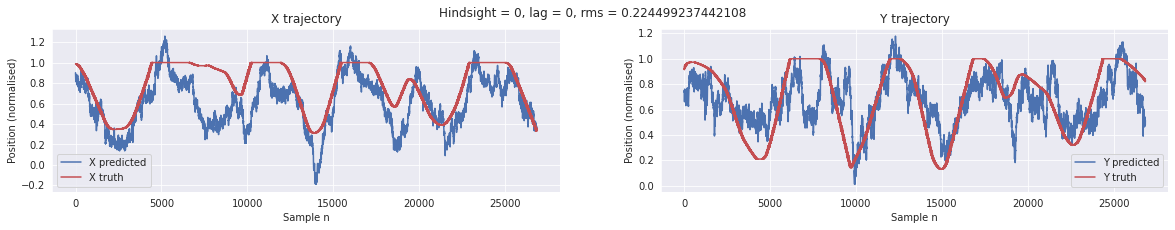

In [ ]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(x_traj_pred, label="X predicted")
plt.plot(x_traj_true, label="X truth", color='#C44E52')
plt.title('X trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_traj_pred, label="Y predicted")
plt.plot(y_traj_true, label="Y truth", color='#C44E52')
plt.title('Y trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.suptitle('Hindsight = {}, lag = {}, rms = {}'.format(h, l, final_rms))

print(h, l, w, f)




In [ ]:
def bin_trajectory(x, y, nbins):
  
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = len(bin_x[0])
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory")
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory", color='#C44E52')


1343


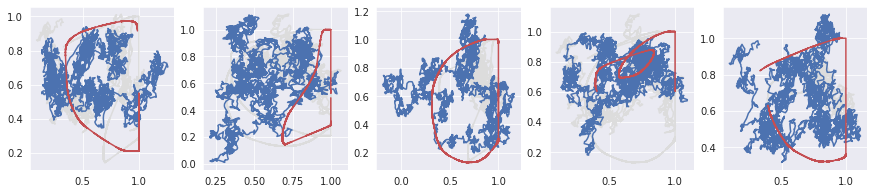

In [ ]:
plot_trajectories(x_traj_true, y_traj_true, x_traj_pred, y_traj_pred, 5, True)


In [ ]:
def LR(h, l, w, f):
  x, y = construct_matrices(V, cx, cy, h, l, w, f)

  print(x)
  print(y)
  print(x.shape, y.shape)

  boundary = 0.8
  no_samples = x.shape[0]

  cutoff = int(np.floor(boundary*no_samples))

  x_train, x_test = x[:cutoff], x[cutoff:]
  y_train, y_test = y[:cutoff], y[cutoff:]

  print("number of training samples: {}, number of testing samples: {}".format(x_train.shape[0], x_test.shape[0]))

  print(x_train.shape, y_train.shape, y_test.shape)
  model = LR_fit(x_train, y_train)
  y_pred = LR_predict(x_test, model)

  yi = int(y.shape[1]/2)

  y_extracted_true = y_test[:, [0, yi]]
  x_traj_true = y_extracted_true[:,0].tolist()
  y_traj_true = y_extracted_true[:,1].tolist()

  y_extracted_pred = y_pred[:, [0, yi]]
  x_traj_pred = y_extracted_pred[:,0].tolist()
  y_traj_pred = y_extracted_pred[:,1].tolist()

  traj_preds = [x_traj_pred, y_traj_pred]
  traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
  traj_true = [x_traj_true, y_traj_true]
  traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
  final_rms = rms(traj_preds, traj_true)
  
  return final_rms

In [ ]:
# RMS heatmap, total RMS (not normalised)

hs = range(0, 15)
ls = range(100, 1600, 100)
rmss = np.zeros((len(hs), len(ls)))
for i, h in enumerate(hs):
    for j, l in enumerate(ls):
      print(h, l)
      rmss[i, j] = LR(h, l, 0, 2)
        



0 100
(134280, 64)
[[0.3242 0.2795 0.515  ... 0.4915 0.4192 0.449 ]
 [0.3184 0.267  0.502  ... 0.48   0.406  0.4463]
 [0.3113 0.2542 0.4885 ... 0.469  0.395  0.4438]
 ...
 [0.5195 0.568  0.5244 ... 0.724  0.665  0.6187]
 [0.527  0.577  0.5356 ... 0.736  0.6743 0.6226]
 [0.525  0.578  0.536  ... 0.744  0.6772 0.623 ]]
[[0.05450606 0.         0.05450606 0.59254738 0.         0.59254738]
 [0.05450606 0.05450606 0.         0.59254738 0.59254738 0.        ]
 [0.05450606 0.         0.05450606 0.59254738 0.         0.59254738]
 ...
 [0.32972198 0.36234626 0.34601886 0.82116153 0.83703116 0.82921842]
 [0.34601886 0.32972198 0.36234626 0.82921842 0.82116153 0.83703116]
 [0.34601886 0.32972198 0.36234626 0.82921842 0.82116153 0.83703116]]
(134280, 64) (134280, 6)
number of training samples: 107424, number of testing samples: 26856
(107424, 64) (107424, 6) (26856, 6)
0 200
(134280, 64)
[[0.3242 0.2795 0.515  ... 0.4915 0.4192 0.449 ]
 [0.3184 0.267  0.502  ... 0.48   0.406  0.4463]
 [0.3113 0.254

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


TypeError: ignored

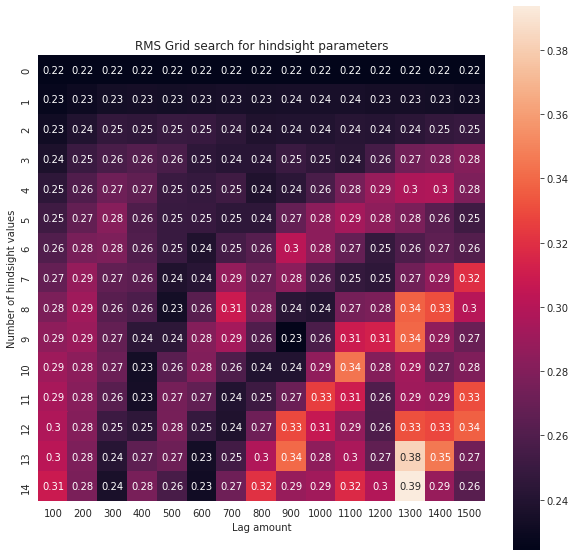

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
sns.heatmap(rmss, annot=True, xticklabels=ls, yticklabels=hs)
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Lag amount')
plt.ylabel('Number of hindsight values')
plt.title('RMS Grid search for hindsight parameters')

h_optimal, l_optimal = np.where(rmss==np.min(rmss))
print(h_optimal, l_optimal)
l_optimal = ls[l_optimal.squeeze()]
print(h_optimal, l_optimal)

In [ ]:
 # sliding window heatmap, total RMS (not normalised)

ws = range(0, 1000, 10)
rmss = np.zeros((len(ws), ))
for i, w in enumerate(ws):
    rmss[i] = LR(0, 0, w, 2)

   



Text(0, 0.5, 'RMS')

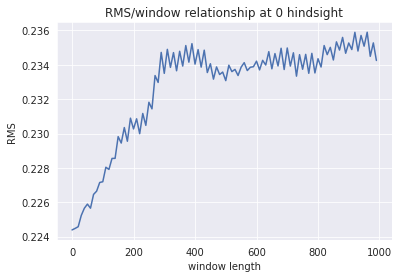

In [ ]:
plt.plot(ws, rmss)  
plt.title('RMS/window relationship at 0 hindsight')
plt.xlabel('window length')
plt.ylabel('RMS')

In [ ]:
def MA(signal, window):
    hindsight = []
    signal_smoothed = []
    for i in range(len(signal)):
        hindsight.append(signal[i])
        if len(hindsight) > window:
            hindsight.pop(0)
        signal_smoothed.append(np.mean(hindsight))
    return signal_smoothed
    
def smooth_prediction(signal, window):
    out = np.zeros_like(signal)
    out[:,0] = MA(signal[:,0], window)
    out[:,1] = MA(signal[:,1], window)
    return out
    

74


Text(0, 0.5, 'RMS')

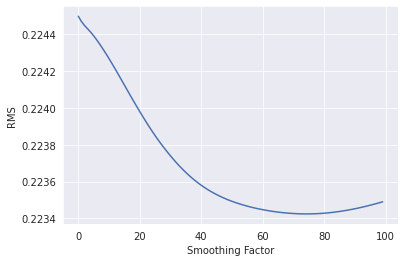

In [ ]:
rmss_smoothing = []
smoothing_values = []
for s in range(100):
  smooth = s+1
  y_traj_pred_smooth = MA(y_traj_pred, smooth)
  x_traj_pred_smooth = MA(x_traj_pred, smooth)

  traj_total = [x_traj_pred_smooth, y_traj_pred_smooth]
  traj_total = [item for sublist in traj_total for item in sublist]

  rmss_smoothing.append(rms(traj_total, traj_true))
  smoothing_values.append(s)

plt.plot(rmss_smoothing)
print(smoothing_values[rmss_smoothing.index(min(rmss_smoothing))])
plt.xlabel("Smoothing Factor")
plt.ylabel("RMS")

0 0 2 2
1343


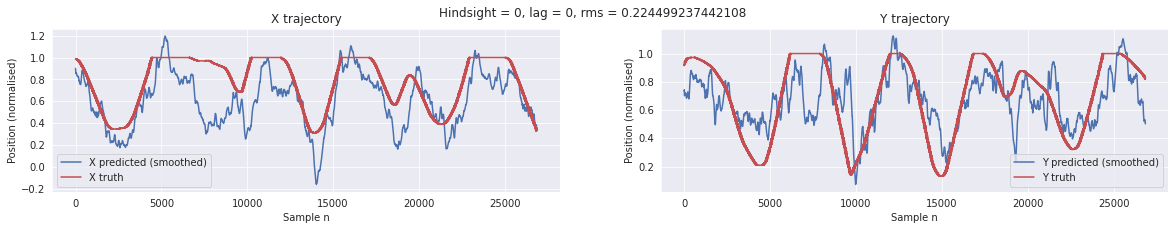

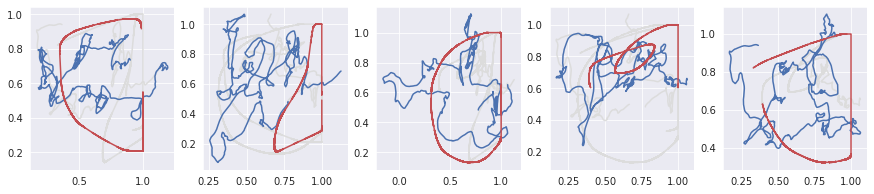

In [ ]:
y_traj_pred_smooth = MA(y_traj_pred, 74)
x_traj_pred_smooth = MA(x_traj_pred, 74)

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(x_traj_pred_smooth, label="X predicted (smoothed)")
plt.plot(x_traj_true, label="X truth", color='#C44E52')
plt.title('X trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_traj_pred_smooth, label="Y predicted (smoothed)")
plt.plot(y_traj_true, label="Y truth", color='#C44E52')
plt.title('Y trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.suptitle('Hindsight = {}, lag = {}, rms = {}'.format(h, l, final_rms))

print(h, l, w, f)


plot_trajectories(x_traj_true, y_traj_true, x_traj_pred_smooth, y_traj_pred_smooth, 5, True)
